# **Project Code | PH3406 - Open Quantum Systems**
## **Quantum State Tomography of a Two-qubit System**
### *Oscar Stommendal, Spring 2025*

##### **Note on the source code** 
The foundation of the source code used in this project is taken from [Qiskit's](https://qiskit-c≈ommunity.github.io/qiskit-experiments/manuals/verification/state_tomography.html) experiment manual on Quantum State Tomography, with some minor adjustments made by me to achieve the goals of this project.

In [1]:
### Import statements and plot settings ###

import qiskit
from qiskit.compiler import transpile

from qiskit_aer import AerSimulator, StatevectorSimulator
from qiskit_aer.noise import NoiseModel, ReadoutError, depolarizing_error

from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography

import cvxpy

import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Latex font style
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=18)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
plt.rcParams['text.latex.preamble'] = r'\usepackage{braket}'

# Set ticks on both sides
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True


In [2]:
### Function definitions ###

def get_QST_qc(Nq, noise=False, noise_choice='depol', output=False):
    '''
    Function to get the quantum circuit for QST with or without noise.

    Args: 
        Nq (int): Number of qubits,
        noise (bool): Whether to include noise in the simulation,
        noise_choice (str): Type of noise to include (depol, meas, both),
        output (bool): Whether to output the state and density matrix of the ideal circuit.
    
    Returns:
        if output:
            None
        else:
            if noise:
                noise_backend (AerSimulator): Backend with noise,
                trans_qc (QuantumCircuit): Transpiled quantum circuit with noise.
            else:
                ideal_backend (AerSimulator): Ideal backend,
                qc_ghz (QuantumCircuit): Ideal quantum circuit.
    '''
    ideal_backend = AerSimulator() # Ideal backend

    # State preparation circuit 
    qc_ghz = qiskit.QuantumCircuit(Nq, Nq) # Create a quantum circuit with nq qubits (the other nq is for the classical register, not used in the state tomography)
    qc_ghz.h(0) # Apply a Hadamard gate on the first qubit
    qc_ghz.s(0) # Apply a S gate on the first qubit
    qc_ghz.cx(0, 1) # Apply a CNOT gate between the first and second qubit

    # If output is True, display the state and density matrix of the original state
    if output:
        backend = StatevectorSimulator() # Use the statevector simulator to get the state
        job = backend.run(qc_ghz) # Run the job
        result = job.result() # Get the result
        state = result.get_statevector(qc_ghz) # Get the state

        # Display the state and density matrix
        display(Markdown('### Original state: '))
        display(state.draw('latex'))

        display(Markdown('### Original density matrix: '))
        display(sp.Matrix(np.outer(state, np.conj(state)))) # rho = |psi><psi|

        return

    # Add noise if specified
    if noise:
        if noise_choice == 'depol':
            prob_1 = 0.1  # 1-qubit gate error probability
            prob_2 = 0.2  # 2-qubit gate error probability
            error_1 = depolarizing_error(prob_1, 1) # 1-qubit gate error
            error_2 = depolarizing_error(prob_2, 2) # 2-qubit gate error

            # Add errors to noise model
            noise_model = NoiseModel() # Create a noise model
            noise_model.add_all_qubit_quantum_error(error_1, ['h', 's']) # Add the 1-qubit errors to the noise model
            noise_model.add_all_qubit_quantum_error(error_2, ['cx']) # Add the 2-qubit errors to the noise model

            noise_backend = AerSimulator(noise_model=noise_model) # Noise simulator
            trans_qc = transpile(qc_ghz, noise_backend) # Transpile the circuit to the noise model (in order to apply the noise)

        elif noise_choice == 'meas':
            probs = np.zeros((Nq, Nq)) # Create an error probability matrix
            for i in range(0, Nq):
                for j in range(0, Nq):
                    if i == j:
                        probs[i, j] = 0.9 # Probability of correct measurement
                    else:
                        probs[i, j] = 0.1 # Probability of incorrect measurement

            readout_error = ReadoutError(probs)  # Create a readout error object
            
            noise_model = NoiseModel() # Create a noise model
            noise_model.add_all_qubit_readout_error(readout_error) # Add the error to both qubits
            
            noise_backend = AerSimulator(noise_model=noise_model) # Noise simulator
            trans_qc = transpile(qc_ghz, noise_backend) # Transpile the circuit to the noise model (in order to apply the noise)
        
        elif noise_choice == 'both':
            # Add depolarizing errors to the noise model
            prob_1 = 0.1 # 1-qubit gate error probability
            prob_2 = 0.2 # 2-qubit gate error probability
            error_1 = depolarizing_error(prob_1, 1) # 1-qubit gate error
            error_2 = depolarizing_error(prob_2, 2) # 2-qubit gate error

            noise_model = NoiseModel() # Create a noise model
            noise_model.add_all_qubit_quantum_error(error_1, ['h', 's']) # Add the 1-qubit errors to the noise model
            noise_model.add_all_qubit_quantum_error(error_2, ['cx']) # Add the 2-qubit errors to the noise model

            # Add readout errors to the noise model
            probs = np.zeros((Nq, Nq)) # Create an error probability matrix
            for i in range(0, Nq):
                for j in range(0, Nq):
                    if i == j:
                        probs[i, j] = 0.9 # Probability of correct measurement
                    else:
                        probs[i, j] = 0.1 # Probability of incorrect measurement
            
            readout_error = ReadoutError(probs)  # Create a readout error object

            noise_model.add_all_qubit_readout_error(readout_error) # Add the error to both qubits

            noise_backend = AerSimulator(noise_model=noise_model) # Noise simulator
            trans_qc = transpile(qc_ghz, noise_backend) # Transpile the circuit to the noise model (in order to apply the noise)
            
        return noise_backend, trans_qc  # Return the backend with noise and the circuit

    return ideal_backend, qc_ghz  # Return the ideal backend and the circuit if no noise

def get_QST_data(counts, Nq, noise=False, noise_choice='device', fitter='auto'):
    '''
    Function to get the QST data for a given number of qubits and noise model.

    Args:
        counts (int): Number of shots in the QST experiment,
        Nq (int): Number of qubits,
        noise (bool): Whether to include noise in the simulation,
        noise_choice (str): Type of noise to include (depol, meas, both),
        fitter (str): Fitter to use for the QST experiment.
    
    Returns:
        qst_data (StateTomographyData): QST data for the given
                                        number of qubits and noise model.
    '''

    # Get the backend and quantum circuit from the get_QST_qc() function
    backend, qc = get_QST_qc(Nq, noise=noise, noise_choice=noise_choice)

    qst = StateTomography(qc) # Create a state tomography experiment

    # Set the fitter
    if fitter == 'cvxpy':
        qst.analysis.set_options(fitter='cvxpy_gaussian_lstsq')

    # Run the experiment
    qst_data = qst.run(backend=backend, shots=counts).block_for_results()

    return qst_data

def plot_density_matrix(rho, noise_choice):
    '''
    Function to visualize the density matrix. Implemented in cooperation with ChatGPT.

    Args:
        rho (np.array): Density matrix to visualize,
        noise_choice (str): Type of noise included in the simulation.
    
    Returns:
        fig (Figure): Figure object containing the density matrix visualization.
    '''
    n = len(rho) # Dimension of the density matrix
    xpos, ypos = np.meshgrid(range(n), range(n)) # Create a meshgrid for the x and y positions

    xpos = xpos.ravel() # Flatten the x positions
    ypos = ypos.ravel() # Flatten the y positions

    # Get real and imaginary parts
    real_part = np.real(rho.T).flatten()
    imag_part = np.imag(rho.T).flatten()

    # Phases (for coloring, ChatGPT solution)
    phase_real = np.angle(real_part)
    phase_imag = np.angle(imag_part)

    # Colormap based on phase
    cmap = plt.get_cmap("twilight")

    # Create the figure
    fig = plt.figure(figsize=(16, 10))

    # Plot the real part
    ax1 = fig.add_subplot(121, projection="3d")
    ax1.bar3d(
        xpos, # X positions
        ypos, # Y positions
        np.zeros_like(real_part), # Base of the bars
        0.8, # Width of the bars
        0.8, # Depth of the bars
        real_part, # Height of the bars
        color=cmap((phase_real + np.pi) / (2 * np.pi)), # Color based on phase
    )
    # Title and possible axis limits
    ax1.set_title('Re($\\hat{\\rho}$)')
    # ax1.set_zlim(-0.02, 0.52)

    # Plot the imaginary part
    ax2 = fig.add_subplot(122, projection="3d")
    ax2.bar3d(
        xpos, # X positions
        ypos, # Y positions
        np.zeros_like(imag_part), # Base of the bars
        0.8, # Width of the bars
        0.8, # Depth of the bars
        imag_part, # Height of the bars
        color=cmap((phase_imag + np.pi) / (2 * np.pi)), # Color based on phase
    )
    # Title and possible axis limits
    ax2.set_title('Im($\\hat{\\rho}$)')
    ax2.set_zlim(-0.52, 0.52)
    # ax2.set_zticks([-0.5, -0.25, 0, 0.25, 0.5])
    # ax2.tick_params(axis='z', pad=10)

    # Set the x and y ticks along with axis labels
    for ax in [ax1, ax2]:
        # Set xticks in the middle of the bars
        ax.set_xticks([0.4, 1.4, 2.4, 3.4])
        ax.set_yticks([0.4, 1.4, 2.4, 3.4])
        ax.set_xticklabels(['$\\ket{00}$', '$\\ket{10}$', '$\\ket{01}$', '$\\ket{11}$'])
        ax.set_yticklabels(['$\\bra{00}$', '$\\bra{10}$', '$\\bra{01}$', '$\\bra{11}$'])
        # ax.set_xticks([0.4, 1.4])
        # ax.set_yticks([0.4, 1.4])
        # ax.set_xticklabels(['$\\ket{0}$', '$\\ket{1}$'])
        # ax.set_yticklabels(['$\\bra{0}$', '$\\bra{1}$'])

    # Set the title of the figure depending on the noise model
    if noise_choice == 'both':
        fig.suptitle('\\textbf{{Reconstructed density matrix $\\hat{{\\rho}}$ for both noise models}}', y=0.86)
    elif noise_choice == 'ideal':
        fig.suptitle('\\textbf{{Reconstructed density matrix $\\hat{{\\rho}}$ for an ideal simulation}}', y=0.86)
    elif noise_choice == 'depol':
        fig.suptitle('\\textbf{{Reconstructed density matrix $\\hat{{\\rho}}$ for the depolarizing noise model}}', y=0.86)
    elif noise_choice == 'meas':
        fig.suptitle('\\textbf{{Reconstructed density matrix $\\hat{{\\rho}}$ for the measurement noise model}}', y=0.86)
    # fig.suptitle('\\textbf{{Reconstructed density matrix $\\hat{{\\rho}}$ for qubit 2 \\& 4 during the parallel experiments}}', y=0.86)

    plt.tight_layout()
    plt.show()

    return fig

def save_data(data, noise, noise_choice, fitter):
    '''
    Function to save the data from the QST experiment to a CSV file.

    Args:
        data (StateTomographyData): Data from the QST experiment,
        noise (bool): Whether noise was included in the simulation,
        noise_choice (str): Type of noise included (depol, meas, both),
        fitter (str): Fitter used for the QST experiment (if this is 'parallel', 
                      the data is saved in the 'parallel' folder, indicating a
                      parallel experiment).
    '''

    dens = np.array(data.analysis_results()[0].value) # Density matrix
    fid = data.analysis_results()[1].value # Fidelity
    extra = data.analysis_results("state").extra # Extra information (e.g. fitter and eigenvalues)

    # Set the filename for the file containing the data and the density matrix
    filename = f'QST_data_{noise_choice}_{noise}_{fitter}.csv'
    filename_dens = f'density_matrix_{noise_choice}_{noise}_{fitter}.csv'

    # Depending on if this was a parallel experiment, save the data in the correct folder
    if fitter == 'parallel':
        filename = 'data/parallel/' + filename
        filename_dens = 'data/parallel/' + filename_dens
    else:
        filename = 'data/' + filename
        filename_dens = 'data/' + filename_dens

    np.savetxt(filename_dens, dens, delimiter=',') # Save the density matrix to a CSV file

    # Save the fidelity and extra information to a CSV file
    with open(filename, 'w') as f:
        f.write(f'fidelity: {fid}\n')
        for key, value in extra.items():
            f.write(f'{key}: {value}\n')

def read_density_matrix(dens_filename):
    '''
    Function to read the density matrix from a CSV file.

    Args:
        dens_filename (str): Filename of the CSV file containing the density matrix.
    
    Returns:
        dens (np.array): Density matrix read from the CSV file.
    '''
    # Use numpy to read the density matrix from the CSV file
    dens = np.loadtxt(dens_filename, delimiter=',', dtype=complex)
    
    return dens
    

In [ ]:
### Visualize the density matrix of the original/ideal state ###

# Run the get_QST_qc() function with output=True to display the state and density matrix of the original state
get_QST_qc(2, output=True)


### Original state: 

<IPython.core.display.Latex object>

### Original density matrix: 

Matrix([
[  0.5, 0, 0, -0.5*I],
[    0, 0, 0,      0],
[    0, 0, 0,      0],
[0.5*I, 0, 0,    0.5]])

In [ ]:
### Run the QST experiment with different noise models and fitters ###

Nq = 2 # Number of qubits
counts = 10000 # Number of shots in the QST experiment

data_ideal = get_QST_data(counts, Nq, noise=False) # Ideal simulation
# save_data(data_ideal, 2, False, 'ideal') # Save the data to a CSV file

data_noise_depol = get_QST_data(counts, Nq, noise=True, noise_choice='depol') # Depolarizing noise
# save_data(data_noise_depol, 2, True, 'depol') # Save the data to a CSV file

data_noise_meas = get_QST_data(counts, Nq, noise=True, noise_choice='meas') # Measurement noise
# save_data(data_noise_meas, 2, True, 'meas') # Save the data to a CSV file

data_noise_both = get_QST_data(counts, Nq, noise=True, noise_choice='both') # Both noise models
# save_data(data_noise_both, 2, True, 'both') # Save the data to a CSV file

data_noise_depol_cvxpy = get_QST_data(counts, Nq, noise=True, noise_choice='depol', fitter='cvxpy') # Depolarizing noise with CVXPY fitter
# save_data(data_noise_depol_cvxpy, 2, True, 'depol', 'cvxpy') # Save the data to a CSV file

data_noise_meas_cvxpy = get_QST_data(counts, Nq, noise=True, noise_choice='meas', fitter='cvxpy') # Measurement noise with CVXPY fitter
# save_data(data_noise_meas_cvxpy, 2, True, 'meas', 'cvxpy') # Save the data to a CSV file


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'execution': {'meas_type': 'classified'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'execution': {'meas_type': 'classified'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'execution': {'meas_type': 'classified'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/Library/Frameworks/Python.framework/Versions/

/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_71904/1082229729.py:228: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


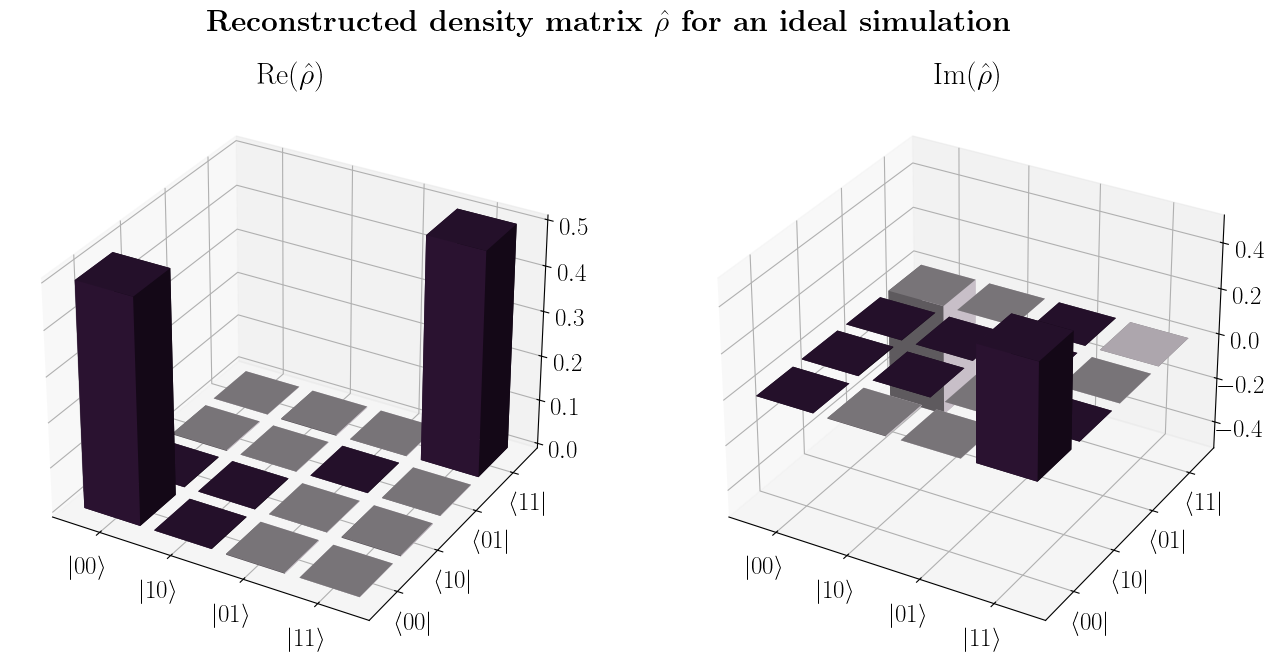

/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_71904/1082229729.py:228: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


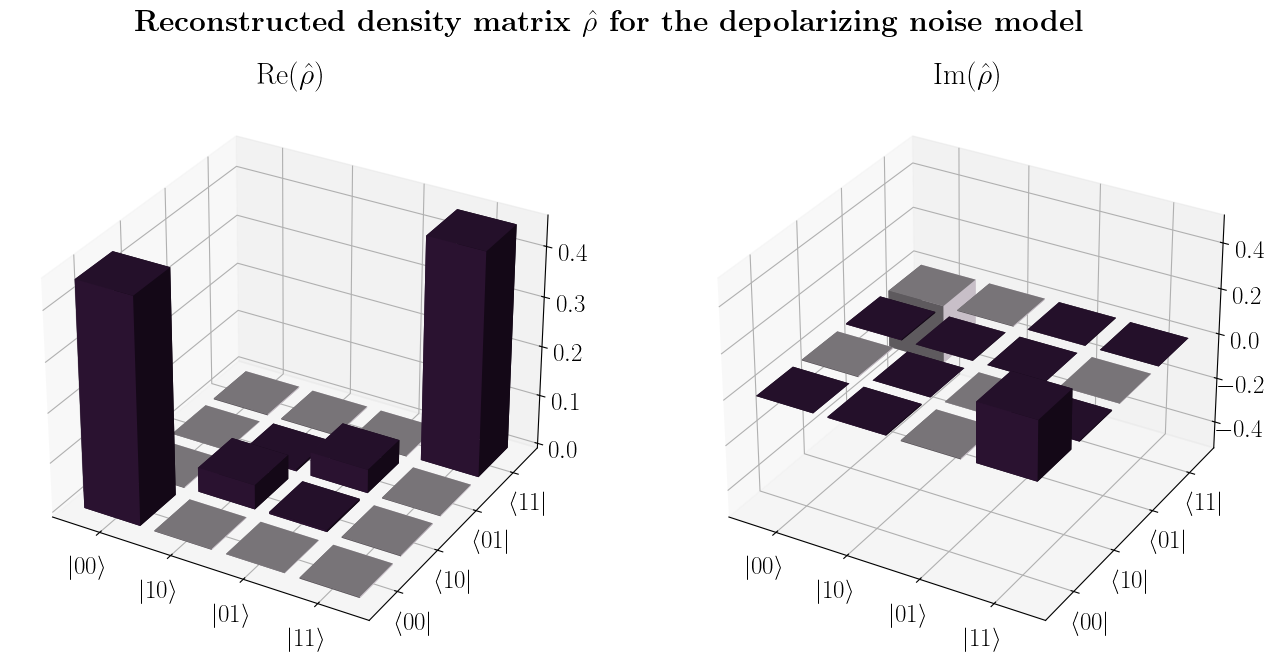

/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_71904/1082229729.py:228: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


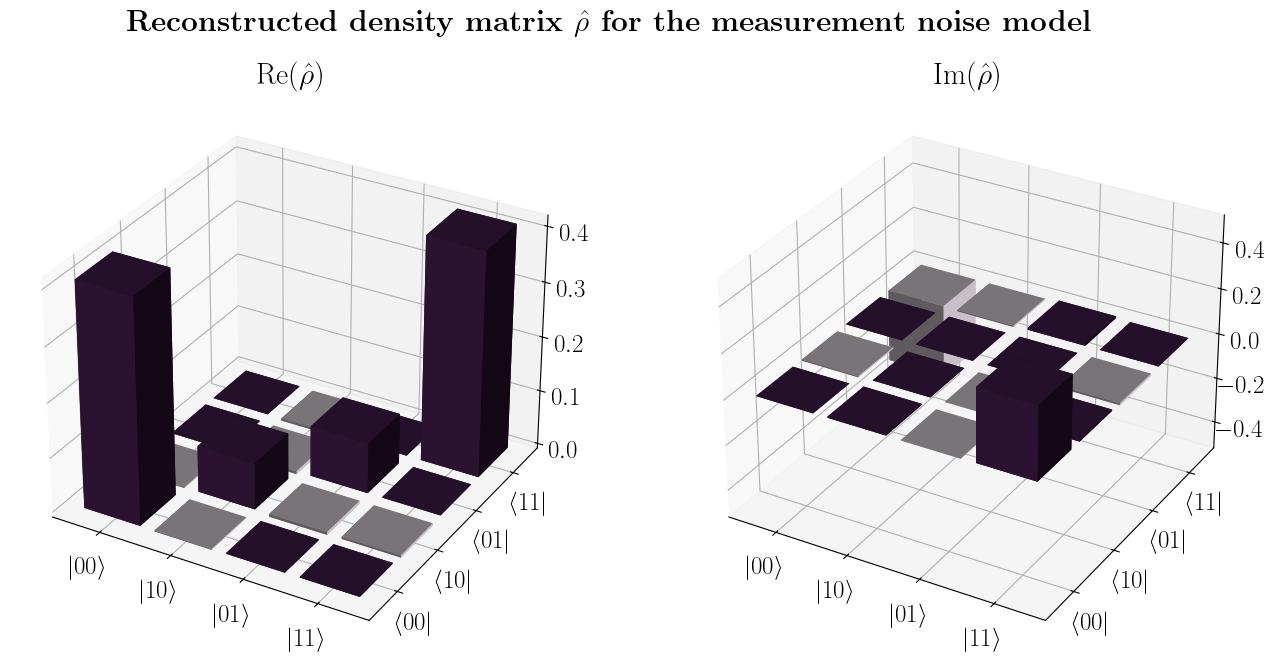

/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_71904/1082229729.py:228: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


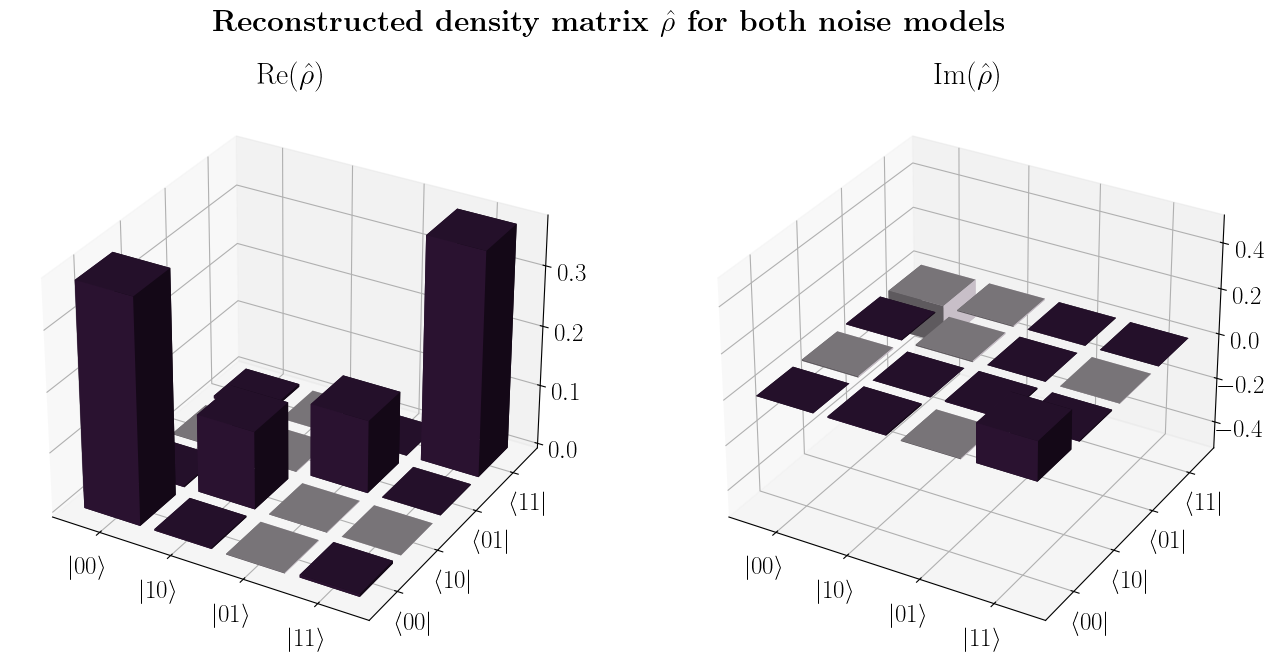

/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_71904/1082229729.py:228: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


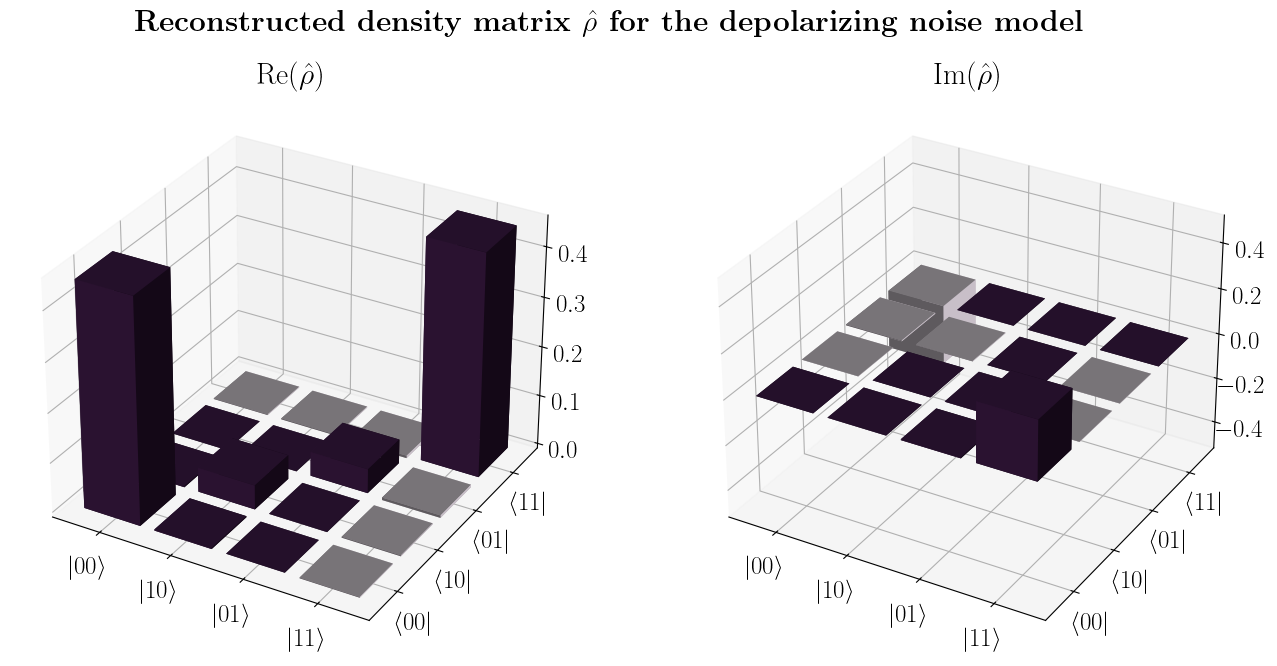

/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_71904/1082229729.py:228: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


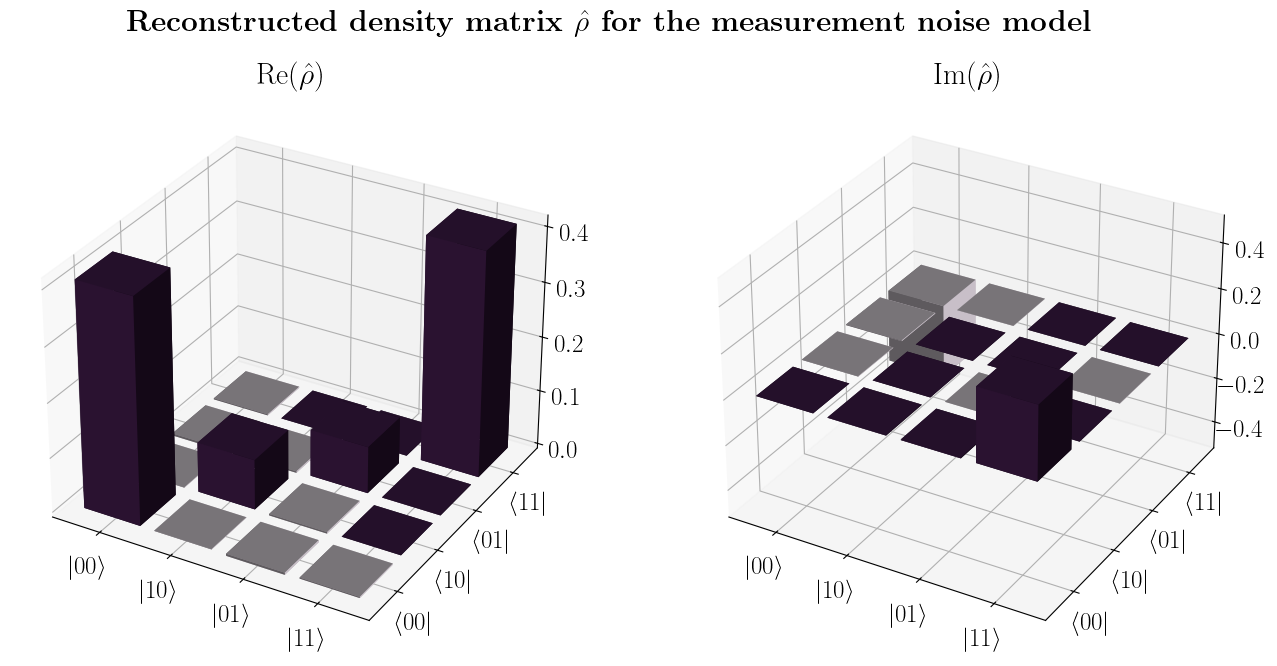

In [6]:
### Read the density matrices from the CSV files and plot them ###

dens_ideal = read_density_matrix('data/density_matrix_ideal_False.csv') # Ideal simulation
fig = plot_density_matrix(dens_ideal, 'ideal') # Plot the density matrix
# fig.savefig('figs/density_matrix_ideal.pdf') # Save the figure

dens_depol = read_density_matrix('data/density_matrix_depol_True.csv') # Depolarizing noise
fig = plot_density_matrix(dens_depol, 'depol') # Plot the density matrix
# fig.savefig('figs/density_matrix_depol.pdf') # Save the figure

dens_meas = read_density_matrix('data/density_matrix_meas_True.csv') # Measurement noise
fig = plot_density_matrix(dens_meas, 'meas') # Plot the density matrix
# fig.savefig('figs/density_matrix_meas.pdf') # Save the figure

dens_both = read_density_matrix('data/density_matrix_both_True.csv') # Both noise models
fig = plot_density_matrix(dens_both, 'both') # Plot the density matrix
# fig.savefig('figs/density_matrix_both.pdf') # Save the figure

dens_depol_cvxpy = read_density_matrix('data/density_matrix_depol_True_cvxpy.csv') # Depolarizing noise with CVXPY fitter
fig = plot_density_matrix(dens_depol_cvxpy, 'depol') # Plot the density matrix
# fig.savefig('figs/density_matrix_depol_cvxpy.pdf') # Save the figure

dens_meas_cvxpy = read_density_matrix('data/density_matrix_meas_True_cvxpy.csv') # Measurement noise with CVXPY fitter
fig = plot_density_matrix(dens_meas_cvxpy, 'meas') # Plot the density matrix
# fig.savefig('figs/density_matrix_meas_cvxpy.pdf') # Save the figure


In [ ]:
### Perform the parallel experiments and save the data ###

# Add depolarizing noise
prob_1 = 0.1  # 1-qubit gate error probability
prob_2 = 0.2  # 2-qubit gate error probability
error_1 = depolarizing_error(prob_1, 1) # 1-qubit gate error
error_2 = depolarizing_error(prob_2, 2) # 2-qubit gate error

noise_model = NoiseModel() # Create a noise model
noise_model.add_all_qubit_quantum_error(error_1, ['h', 's', 'x']) # Add the 1-qubit errors to the noise model
noise_model.add_all_qubit_quantum_error(error_2, ['cx']) # Add the 2-qubit errors to the noise model

backend = AerSimulator(noise_model=noise_model) # Noise simulator

Nq = 5 # Number of qubits
counts = 10000 # Number of shots in the QST experiments

# Define the gates for the parallel experiments
gates = [
         qiskit.circuit.library.HGate(), 
         qiskit.circuit.library.SGate(), 
         qiskit.circuit.library.CXGate(), 
         qiskit.circuit.library.XGate()
        ]

# State tomography for the parallel experiments on the qubits
subexps = [
    StateTomography(gates[0], physical_qubits=(0, )), 
    StateTomography(gates[1], physical_qubits=(2, )), 
    StateTomography(gates[2], physical_qubits=(1, 3)), 
    StateTomography(gates[3], physical_qubits=(4, ))
]

# Create a parallel experiment
parexp = ParallelExperiment(subexps, flatten_results=False)

# Run the experiment
pardata = parexp.run(backend, shots=counts).block_for_results()

# Extract the results, print the state fidelity and state and save the data
sp.init_printing()
for i, expdata in enumerate(pardata.child_data()):
    state_result_i = expdata.analysis_results("state") # State
    fid_result_i = expdata.analysis_results("state_fidelity") # State fidelity

    print(f'\nPARALLEL EXP {i}')
    print("State Fidelity: {:.5f}".format(fid_result_i.value)) # Print the state fidelity
    print("State: ")
    display(sp.Matrix(state_result_i.value)) # Display the state
    save_data(expdata, True, f'parexp_{i}', 'parallel') # Save the data to a CSV file


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'execution': {'meas_type': 'classified'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")



PARALLEL EXP 0
State Fidelity: 0.90370
State: 


⎡            0.4894               0.4037 + 0.000499999999999973⋅ⅈ⎤
⎢                                                                ⎥
⎣0.4037 - 0.000499999999999973⋅ⅈ              0.5106             ⎦


PARALLEL EXP 1
State Fidelity: 0.94970
State: 


⎡            0.9497               -0.00480000000000003 + 0.0109⋅ⅈ⎤
⎢                                                                ⎥
⎣-0.00480000000000003 - 0.0109⋅ⅈ         0.050300000000001       ⎦


PARALLEL EXP 2
State Fidelity: 0.84692
State: 


⎡             0.846916666666667                -0.00278333333333333 - 0.004149 ↪
⎢                                                                              ↪
⎢-0.00278333333333333 + 0.00414999999999999⋅ⅈ               0.0503166666666676 ↪
⎢                                                                              ↪
⎢-0.00523333333333332 + 0.00116666666666669⋅ⅈ  0.000649999999999998 + 0.001699 ↪
⎢                                                                              ↪
⎣      -0.00385000000000001 + 0.0069⋅ⅈ         0.00196666666666665 - 0.0002333 ↪

↪ 99999999999⋅ⅈ  -0.00523333333333332 - 0.00116666666666669⋅ⅈ        -0.003850 ↪
↪                                                                              ↪
↪                0.000649999999999998 - 0.00169999999999999⋅ⅈ  0.0019666666666 ↪
↪                                                                              ↪
↪ 99999999999⋅ⅈ               0.0522833333333342               0.0018166666666 ↪
↪                          


PARALLEL EXP 3
State Fidelity: 0.94940
State: 


⎡             0.0506000000000009                -0.000900000000000012 + 0.0074 ↪
⎢                                                                              ↪
⎣-0.000900000000000012 - 0.00749999999999998⋅ⅈ                     0.9494      ↪

↪ 9999999999998⋅ⅈ⎤
↪                ⎥
↪                ⎦

/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_71904/1082229729.py:228: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


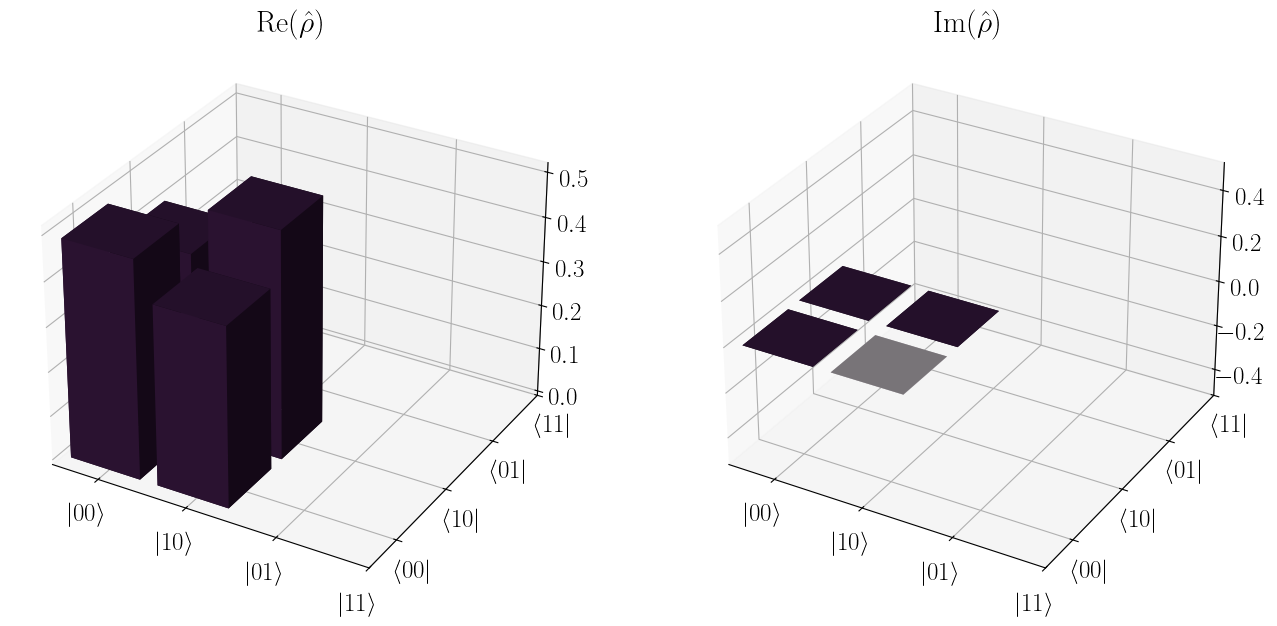

/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_71904/1082229729.py:228: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


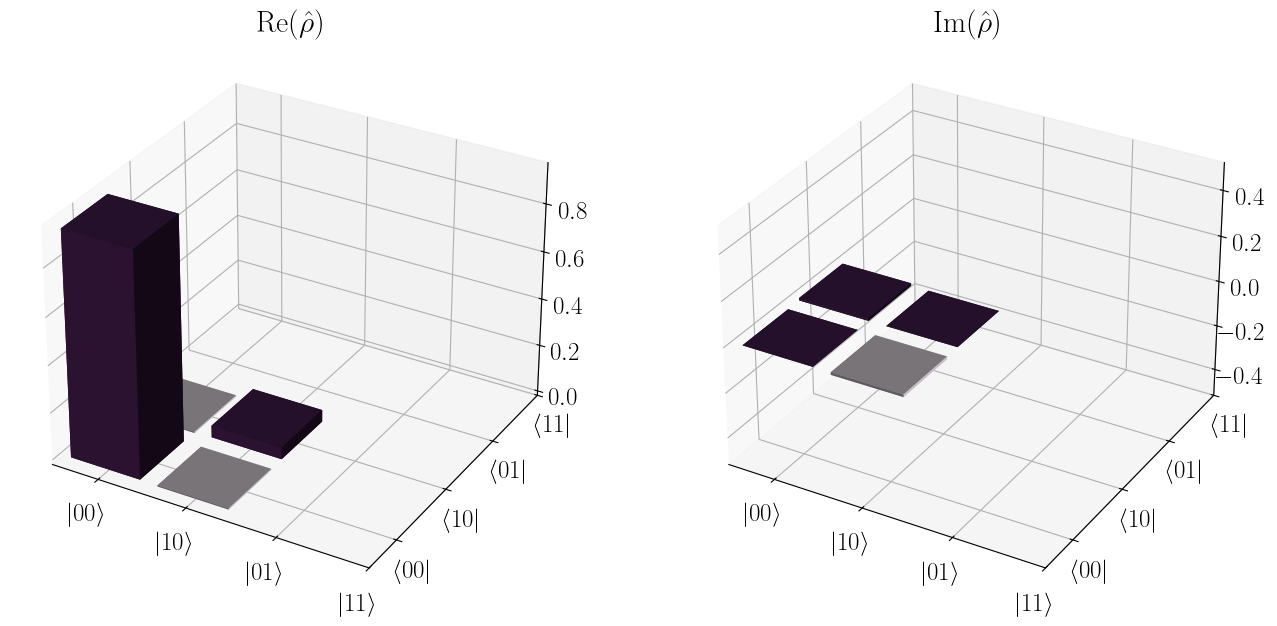

/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_71904/1082229729.py:228: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


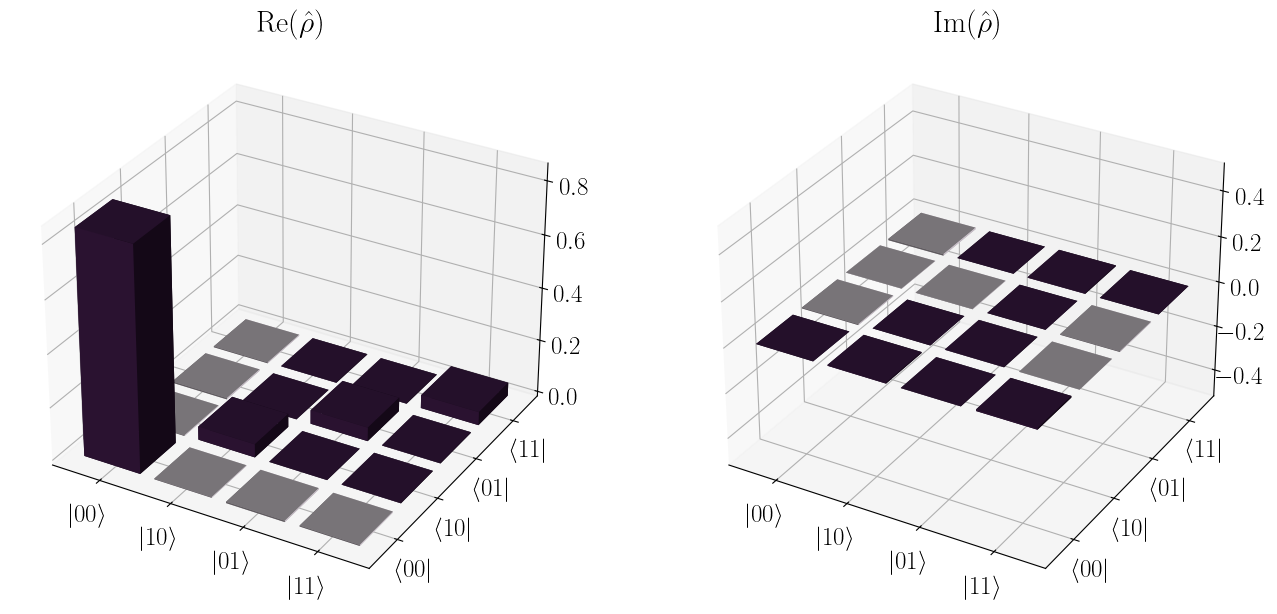

/var/folders/3z/njryns916658jt56y6zm3xfw0000gn/T/ipykernel_71904/1082229729.py:228: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


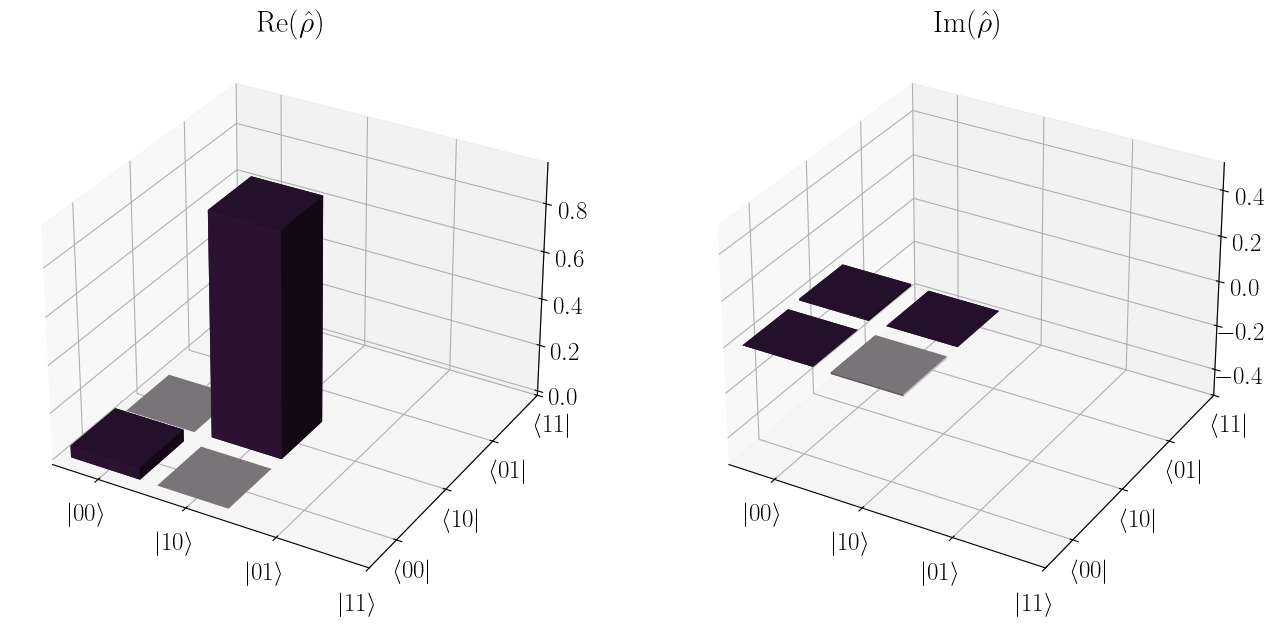

In [7]:
### Read the density matrices from the parallel experiments and plot them ###

par_exp0_dens = read_density_matrix('data/parallel/density_matrix_parexp_0_True_parallel.csv') # Parallel experiment 1
fig = plot_density_matrix(par_exp0_dens, 'parexp_0') # Plot the density matrix
# fig.savefig('figs/parallel/density_matrix_parexp_0.pdf') # Save the figure

par_exp1_dens = read_density_matrix('data/parallel/density_matrix_parexp_1_True_parallel.csv') # Parallel experiment 2
fig = plot_density_matrix(par_exp1_dens, 'parexp_1') # Plot the density matrix
# fig.savefig('figs/parallel/density_matrix_parexp_1.pdf') # Save the figure

par_exp2_dens = read_density_matrix('data/parallel/density_matrix_parexp_2_True_parallel.csv') # Parallel experiment 3
fig = plot_density_matrix(par_exp2_dens, 'parexp_2') # Plot the density matrix
# fig.savefig('figs/parallel/density_matrix_parexp_2.pdf') # Save the figure

par_exp3_dens = read_density_matrix('data/parallel/density_matrix_parexp_3_True_parallel.csv') # Parallel experiment 4
fig = plot_density_matrix(par_exp3_dens, 'parexp_3') # Plot the density matrix
# fig.savefig('figs/parallel/density_matrix_parexp_3.pdf') # Save the figure
